[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/032_optimization/optimization.ipynb)

# Optimización

En este post vamos a ver algunas técnicas que podemos aplicar durante el entrenamiento de nuestras `redes neuronales` para acelerar el proceso de optimización y, potencialmente, obtener mejores resultados de los que hemos sido capaces de obtener hasta ahora. Compararemos estas técnicas en el mismo problema utilizado en el post anterior, la clasificación de imágenes con el dataset CIFAR10.

In [2]:
import torchvision

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

len(trainset), len(testset)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

In [3]:
import numpy as np

train_images = np.array([np.array(img) for img, label in trainset])
X_test = np.array([np.array(img) for img, label in testset])

train_labels = np.array([label for img, label in trainset])
y_test = np.array([label for img, label in testset])

X_train, X_val, X_subset = train_images[:40000], train_images[40000:], train_images[:5000]
y_train, y_val, y_subset = train_labels[:40000], train_labels[40000:], train_labels[:5000]

X_train.shape, X_val.shape, X_test.shape, X_subset.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (10000, 32, 32, 3), (5000, 32, 32, 3))

In [4]:
import torch

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X / 255.).float().cuda().view(-1, 32*32*3)
        self.Y = torch.from_numpy(Y).long().cuda()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

dataset = {
    'train': Dataset(X_subset, y_subset),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(5000, 10000)

In [5]:
from sklearn.metrics import accuracy_score

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def build_model(D_in=32*32*3, H=100, D_out=10):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    ).cuda()

def fit(model, dataloader, optimizer, epochs=100, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc = [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)            
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

## Optimizadores

Hasta este punto, hemos optimizado siempre nuestras redes neuronales con el algoritmo de `stochastic gradient descent`, el cual actualiza los pesos del modelo siguiente la regla $w \leftarrow w - \eta \, \, \frac{dl}{dw}$, dónde $w$ son los parámetros de la red neuronal, $\eta$ es el factor de aprendizaje (o *learning rate*) y $\frac{dl}{dw}$ es la derivada de la función de pérdida con respecto a los parámetros. Puedes aprender todo lo necesario sobre este algoritmo en est [post](https://sensioai.com/blog/013_perceptron2). Si bien este algoritmo funciona y en ocasiones es la mejor elección, existen otros algoritmos de optimización que pueden acelerar el entrenamiento requiriendo muchas menos epochs para alacanzar el mismo resultado, o para el mismo número de epochs encontrar un mejor solución.

![](https://camo.githubusercontent.com/7d81e76398258f79f1d31e59d1ba32575512c4b0/687474703a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f776173736e616d652f76697a5f746f7263685f6f7074696d2f6d61737465722f646f63732f766964656f732f6265616c65735f32303137313131375f30302d30322d32305f32642e676966)

### Momentum

La primera mejora que podemos hacer sobre el algoritmo *SGD* es añadir *momentum*. De la misma manera que una pelota rodando por una superficie inclinada acelera poco a poco debido a la fuerza de la gravedad (a esto se le llama ganar *momentum*) podemos hacer que nuestros pasos de `descenso por gradiente` sean más grandes si el signo del gradiente es el mismo durante *updates* consecutivos.

$$m \leftarrow \beta m - \eta \, \, \frac{dl}{dw}$$


$$w \leftarrow w + m$$

En `Pytorch` podemos controlar el valor de $\beta$ (cuanto *momentum* queremos añadir) con el parámetro `momentum`.

### RMSProp

El algoritmo del `descenso por gradiente` funciona intentando descender rápidamente en la dirección en la que el gradiente es mayor. Sin embargo, esta dirección no tiene porqué ser siempre la que indica el camino hacia el óptimo global. El algoritmo de optimización `RMSProp` intenta tener este factor en cuenta escalando el gradiente en la dimensión con mayor pendiente

$$ s \leftarrow \beta s + (1 - \beta) \frac{dl}{dw} ⊗ \frac{dl}{dw} $$

$$ w \leftarrow w - \eta \frac{dl}{dw} ⊘ \sqrt{s + \epsilon}$$

donde $\beta$ es el *decay rate* (normalmente 0.9) y $\epsilon$ es un valor pequeño para evitar división entre 0. En `Pytorch` podemos usar este optimizador con la clase `torch.optim.RMSProp`.

### Adam

Adam combina las ideas de *momentum* y *RMSProp*, y es la opción elegida por defecto por la mayoría de desarrolladores. 


$$m \leftarrow \beta_1 m - (1 - \beta_1) \, \, \frac{dl}{dw}$$
$$ s \leftarrow \beta_2 s + (1 - \beta_2) \frac{dl}{dw} ⊗ \frac{dl}{dw} $$
$$\hat{m} \leftarrow \frac{m}{1-\beta_1^T}$$
$$\hat{s} \leftarrow \frac{s}{1-\beta_2^T}$$
$$ w \leftarrow w + \eta \hat{m} ⊘ \sqrt{\hat{s} + \epsilon}$$

### Comparativa

Vamos a comparar los diferentes optimizadores presentados.

In [6]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
hist_sgd = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.10420 en epoch 1
Mejor modelo guardado con acc 0.16150 en epoch 2
Mejor modelo guardado con acc 0.16290 en epoch 9
Mejor modelo guardado con acc 0.17730 en epoch 10
Epoch 10/100 loss 2.23530 acc 0.17874 val_loss 2.23722 val_acc 0.17730
Mejor modelo guardado con acc 0.18290 en epoch 11
Mejor modelo guardado con acc 0.19590 en epoch 12
Mejor modelo guardado con acc 0.20520 en epoch 13
Mejor modelo guardado con acc 0.20910 en epoch 14
Mejor modelo guardado con acc 0.21660 en epoch 15
Mejor modelo guardado con acc 0.22770 en epoch 16
Mejor modelo guardado con acc 0.23040 en epoch 17
Mejor modelo guardado con acc 0.24050 en epoch 18
Mejor modelo guardado con acc 0.24150 en epoch 19
Mejor modelo guardado con acc 0.24420 en epoch 20
Epoch 20/100 loss 2.12625 acc 0.25279 val_loss 2.13621 val_acc 0.24420
Mejor modelo guardado con acc 0.24870 en epoch 21
Mejor modelo guardado con acc 0.25760 en epoch 23
Mejor modelo guardado con acc 0.25890 en epoch 24
Mejor model

In [7]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
hist_momentum = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.14880 en epoch 1
Mejor modelo guardado con acc 0.20590 en epoch 2
Mejor modelo guardado con acc 0.25410 en epoch 3
Mejor modelo guardado con acc 0.27220 en epoch 5
Mejor modelo guardado con acc 0.28870 en epoch 6
Mejor modelo guardado con acc 0.30420 en epoch 7
Mejor modelo guardado con acc 0.32020 en epoch 8
Mejor modelo guardado con acc 0.32730 en epoch 9
Epoch 10/100 loss 1.83313 acc 0.34057 val_loss 1.89190 val_acc 0.32100
Mejor modelo guardado con acc 0.34100 en epoch 12
Mejor modelo guardado con acc 0.34330 en epoch 13
Mejor modelo guardado con acc 0.35470 en epoch 14
Mejor modelo guardado con acc 0.35890 en epoch 19
Mejor modelo guardado con acc 0.36060 en epoch 20
Epoch 20/100 loss 1.67874 acc 0.39849 val_loss 1.80767 val_acc 0.36060
Mejor modelo guardado con acc 0.36690 en epoch 21
Mejor modelo guardado con acc 0.36790 en epoch 22
Mejor modelo guardado con acc 0.36800 en epoch 24
Mejor modelo guardado con acc 0.36870 en epoch 25
Mejor modelo gua

In [8]:
model = build_model()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
hist_rms = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.22020 en epoch 1
Mejor modelo guardado con acc 0.23800 en epoch 2
Mejor modelo guardado con acc 0.27260 en epoch 4
Mejor modelo guardado con acc 0.32340 en epoch 5
Mejor modelo guardado con acc 0.32490 en epoch 6
Epoch 10/100 loss 1.68733 acc 0.38615 val_loss 1.99868 val_acc 0.29980
Mejor modelo guardado con acc 0.34360 en epoch 11
Mejor modelo guardado con acc 0.35100 en epoch 14
Mejor modelo guardado con acc 0.35970 en epoch 18
Epoch 20/100 loss 1.53118 acc 0.44307 val_loss 1.82769 val_acc 0.35720
Mejor modelo guardado con acc 0.36920 en epoch 22
Epoch 30/100 loss 1.40338 acc 0.49164 val_loss 1.95557 val_acc 0.34880
Mejor modelo guardado con acc 0.37440 en epoch 33
Mejor modelo guardado con acc 0.38080 en epoch 35
Epoch 40/100 loss 1.30432 acc 0.52946 val_loss 1.93651 val_acc 0.36320
Mejor modelo guardado con acc 0.38560 en epoch 42
Epoch 50/100 loss 1.22572 acc 0.55752 val_loss 2.62911 val_acc 0.27930
Mejor modelo guardado con acc 0.39410 en epoch 51


In [9]:
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
hist_adam = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.28890 en epoch 1
Mejor modelo guardado con acc 0.29750 en epoch 2
Mejor modelo guardado con acc 0.32250 en epoch 3
Mejor modelo guardado con acc 0.34100 en epoch 4
Mejor modelo guardado con acc 0.34480 en epoch 5
Mejor modelo guardado con acc 0.34870 en epoch 6
Mejor modelo guardado con acc 0.37230 en epoch 8
Epoch 10/100 loss 1.58195 acc 0.43292 val_loss 1.80173 val_acc 0.36380
Mejor modelo guardado con acc 0.37680 en epoch 11
Mejor modelo guardado con acc 0.38720 en epoch 13
Mejor modelo guardado con acc 0.38960 en epoch 15
Mejor modelo guardado con acc 0.39030 en epoch 16
Mejor modelo guardado con acc 0.39280 en epoch 19
Mejor modelo guardado con acc 0.39440 en epoch 20
Epoch 20/100 loss 1.35224 acc 0.51911 val_loss 1.74945 val_acc 0.39440
Mejor modelo guardado con acc 0.40050 en epoch 21
Mejor modelo guardado con acc 0.40070 en epoch 24
Mejor modelo guardado con acc 0.40540 en epoch 28
Epoch 30/100 loss 1.17670 acc 0.57604 val_loss 1.83196 val_acc 0.

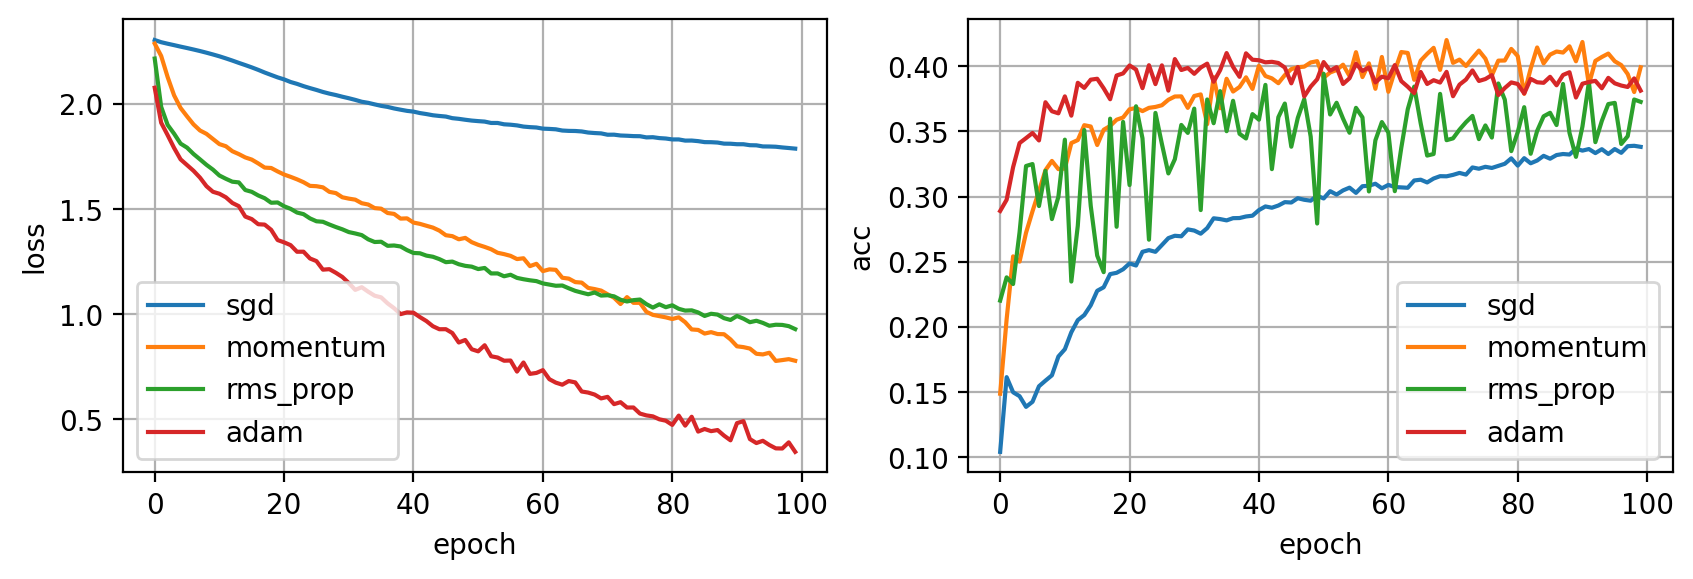

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(hist_sgd['loss'], label="sgd")
ax.plot(hist_momentum['loss'], label="momentum")
ax.plot(hist_rms['loss'], label="rms_prop")
ax.plot(hist_adam['loss'], label="adam")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(hist_sgd['val_acc'], label="sgd")
ax.plot(hist_momentum['val_acc'], label="momentum")
ax.plot(hist_rms['val_acc'], label="rms_prop")
ax.plot(hist_adam['val_acc'], label="adam")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

Como puedes ver, las variantes de *SGD* son capaces de converger mucho más rápido. Aún así, si le damos suficiente tiempo, *SGD* es capaz de llegar a los mismos resultados, e incluso superarlos. Existen muchos otros optimizadores, sin embargo los vistos aquí son los más comunes.

## *Learning Rate Scheduling* 

Otra técninca muy utilizada para acelerar el proceso de entrenamiento de una `red neuronal` es el *learning rate scheduling* y consiste en ir variando el factor de aprendizaje durante el entrenamiento en vez de utilizar un valor fijo. Un valor alto del *learning rate* nos puede dar una ventaja en las fases iniciales del entrenamiento, en las que queremos acercarnos al punto óptimo de manera rápida. Aun así, no nos permitirá llegar al mejor valor posible ya que se quedará oscilando alrededor. En este punto, un learning rate pequeño nos permitiría acercarnos mucho más al valor óptimo, pero tardaría mucho en llegar en primer lugar. 

![](https://camo.githubusercontent.com/051fc8fa68156d721512278e397dab5680dad77a/687474703a2f2f63733233316e2e6769746875622e696f2f6173736574732f6e6e332f6c6561726e696e6772617465732e6a706567)

La idea es combinar varios valores de *learning rate* para aprovechar las ventajas de cada uno en diferentes partes del entrenamiento. `Pytorch` nos ofrece algunos *schedulers* populares que podemos usar en el paquete `torch.optim.lr_scheduler`. Vamos a ver algunos ejemplos.

In [11]:
def fit(model, dataloader, optimizer, scheduler=None, epochs=100, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc, lr = [], [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        for param_group in optimizer.param_groups:
            lr.append(param_group['lr'])
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)            
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        if scheduler:
            scheduler.step()
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f} lr {lr[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc, 'lr': lr}

In [12]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# multiplica el lr por 0.1 cada 10 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.1)

hist_step = fit(model, dataloader, optimizer, scheduler, epochs=30)

Mejor modelo guardado con acc 0.23120 en epoch 1
Mejor modelo guardado con acc 0.24730 en epoch 2
Mejor modelo guardado con acc 0.31640 en epoch 3
Mejor modelo guardado con acc 0.31960 en epoch 4
Mejor modelo guardado con acc 0.33490 en epoch 7
Mejor modelo guardado con acc 0.35660 en epoch 10
Epoch 10/30 loss 1.66539 acc 0.38774 val_loss 1.81151 val_acc 0.35660 lr 0.01000
Mejor modelo guardado con acc 0.38680 en epoch 11
Mejor modelo guardado con acc 0.38830 en epoch 12
Mejor modelo guardado con acc 0.39160 en epoch 14
Mejor modelo guardado con acc 0.39470 en epoch 15
Mejor modelo guardado con acc 0.39730 en epoch 18
Epoch 20/30 loss 1.44433 acc 0.47572 val_loss 1.73696 val_acc 0.39130 lr 0.00100
Epoch 30/30 loss 1.41376 acc 0.49144 val_loss 1.72523 val_acc 0.39570 lr 0.00010


In [13]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# aumenta el lr por 5 epochs, luego decrece
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size_up=5, step_size_down=25)

hist_cycle = fit(model, dataloader, optimizer, scheduler, epochs=30)

Mejor modelo guardado con acc 0.09600 en epoch 1
Mejor modelo guardado con acc 0.21130 en epoch 2
Mejor modelo guardado con acc 0.24520 en epoch 3
Mejor modelo guardado con acc 0.30340 en epoch 4
Mejor modelo guardado con acc 0.32820 en epoch 6
Mejor modelo guardado con acc 0.33400 en epoch 7
Mejor modelo guardado con acc 0.34590 en epoch 8
Mejor modelo guardado con acc 0.35120 en epoch 9
Mejor modelo guardado con acc 0.35670 en epoch 10
Epoch 10/30 loss 1.69888 acc 0.38515 val_loss 1.78754 val_acc 0.35670 lr 0.00842
Mejor modelo guardado con acc 0.37840 en epoch 11
Mejor modelo guardado con acc 0.37920 en epoch 13
Mejor modelo guardado con acc 0.38490 en epoch 15
Mejor modelo guardado con acc 0.39270 en epoch 17
Mejor modelo guardado con acc 0.39310 en epoch 20
Epoch 20/30 loss 1.42060 acc 0.48985 val_loss 1.71428 val_acc 0.39310 lr 0.00446
Mejor modelo guardado con acc 0.40720 en epoch 21
Mejor modelo guardado con acc 0.40920 en epoch 23
Mejor modelo guardado con acc 0.41080 en epoch

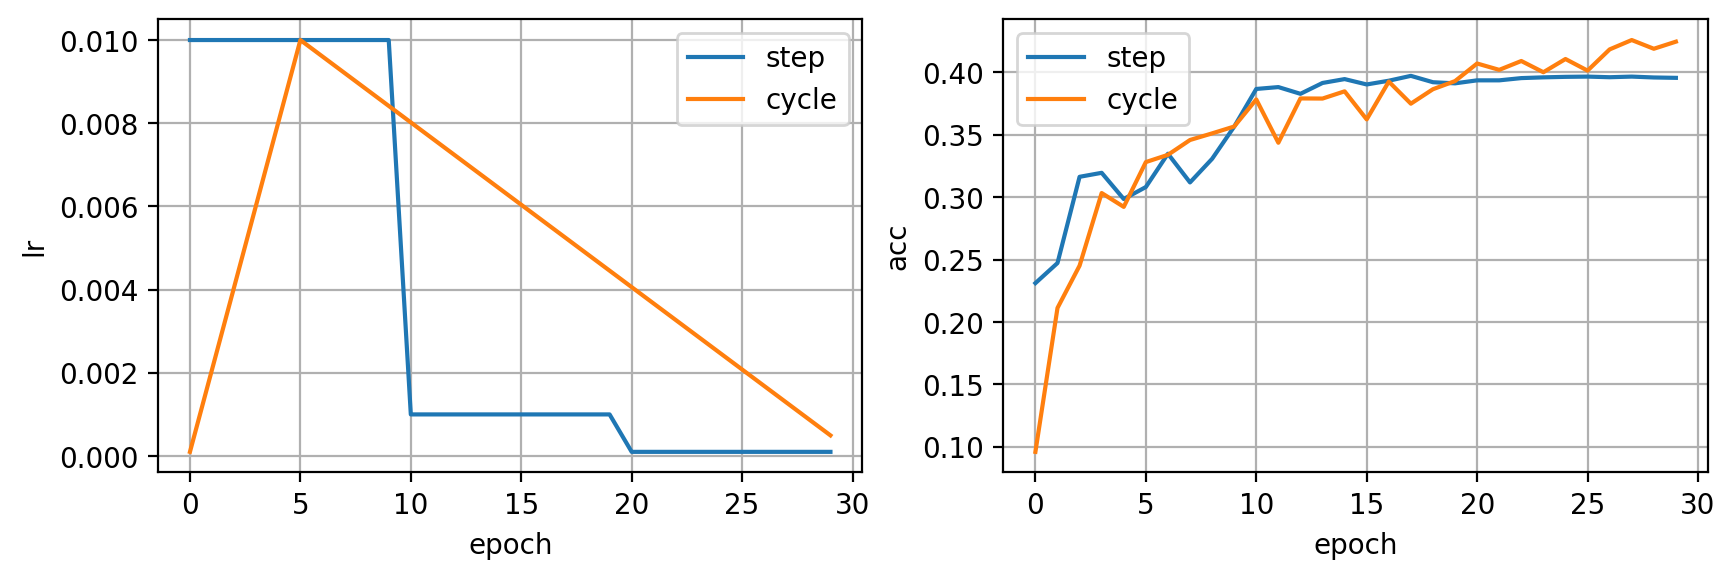

In [14]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(hist_step['lr'], label="step")
ax.plot(hist_cycle['lr'], label="cycle")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('lr')
ax = plt.subplot(122)
ax.plot(hist_step['val_acc'], label="step")
ax.plot(hist_cycle['val_acc'], label="cycle")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

## Normalización

Otra técnica muy importante para acelerar el entrenamiento consiste en normalizar nuestros datos. Esto es algo de lo que ya hemos hablado en posts anteriores, y en este mismo post puedes ver como al principio de todo hemos dividido nuestras imágenes entre 255 de manera que los valores presentes en los tensores que nuestra `red neuronal` usa como entradas estén normalizados entre 0 y 1. Otra normalización popular, cuando trabajamos con imágenes, consiste en calcular el valor medio y desviación estándar de nuestro dataset, y normalizar las imágenes para que tengan media 0 y desviación estándar 1.

In [15]:
import numpy as np

mean = (train_images / 255).mean(axis=(0, 1, 2))
std = (train_images / 255).std(axis=(0, 1, 2))

mean, std

(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

In [16]:
train_images_norm = ((train_images / 255) - mean) / std
train_images_norm.mean(axis=(0, 1, 2)), train_images_norm.std(axis=(0, 1, 2))

(array([-1.62320331e-11, -2.54226058e-11, -5.44383358e-11]),
 array([1., 1., 1.]))

In [17]:
X_test_norm = np.array([(np.array(img)/255. - mean) / std for img, label in testset])

X_train_norm, X_val_norm, X_subset_norm = train_images_norm[:40000], train_images_norm[40000:], train_images_norm[:5000]

X_train_norm.shape, X_val_norm.shape, X_test_norm.shape, X_subset_norm.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (10000, 32, 32, 3), (5000, 32, 32, 3))

In [18]:
dataset_norm = {
    'train': Dataset(X_subset_norm, y_subset),
    'val': Dataset(X_val_norm, y_val),
}

dataloader_norm = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset_norm['train']), len(dataset_norm['val'])

(5000, 10000)

In [19]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
hist_norm = fit(model, dataloader_norm, optimizer)

Mejor modelo guardado con acc 0.20050 en epoch 1
Mejor modelo guardado con acc 0.24410 en epoch 2
Mejor modelo guardado con acc 0.25440 en epoch 3
Mejor modelo guardado con acc 0.27080 en epoch 4
Mejor modelo guardado con acc 0.28070 en epoch 5
Mejor modelo guardado con acc 0.28480 en epoch 6
Mejor modelo guardado con acc 0.30250 en epoch 7
Mejor modelo guardado con acc 0.32040 en epoch 8
Mejor modelo guardado con acc 0.32800 en epoch 9
Mejor modelo guardado con acc 0.33190 en epoch 10
Epoch 10/100 loss 1.82946 acc 0.34514 val_loss 1.87671 val_acc 0.33190 lr 0.00100
Mejor modelo guardado con acc 0.33580 en epoch 11
Mejor modelo guardado con acc 0.34150 en epoch 12
Mejor modelo guardado con acc 0.34490 en epoch 13
Mejor modelo guardado con acc 0.34530 en epoch 15
Mejor modelo guardado con acc 0.36530 en epoch 17
Epoch 20/100 loss 1.67915 acc 0.39889 val_loss 1.82687 val_acc 0.34930 lr 0.00100
Mejor modelo guardado con acc 0.37470 en epoch 23
Mejor modelo guardado con acc 0.37720 en epoc

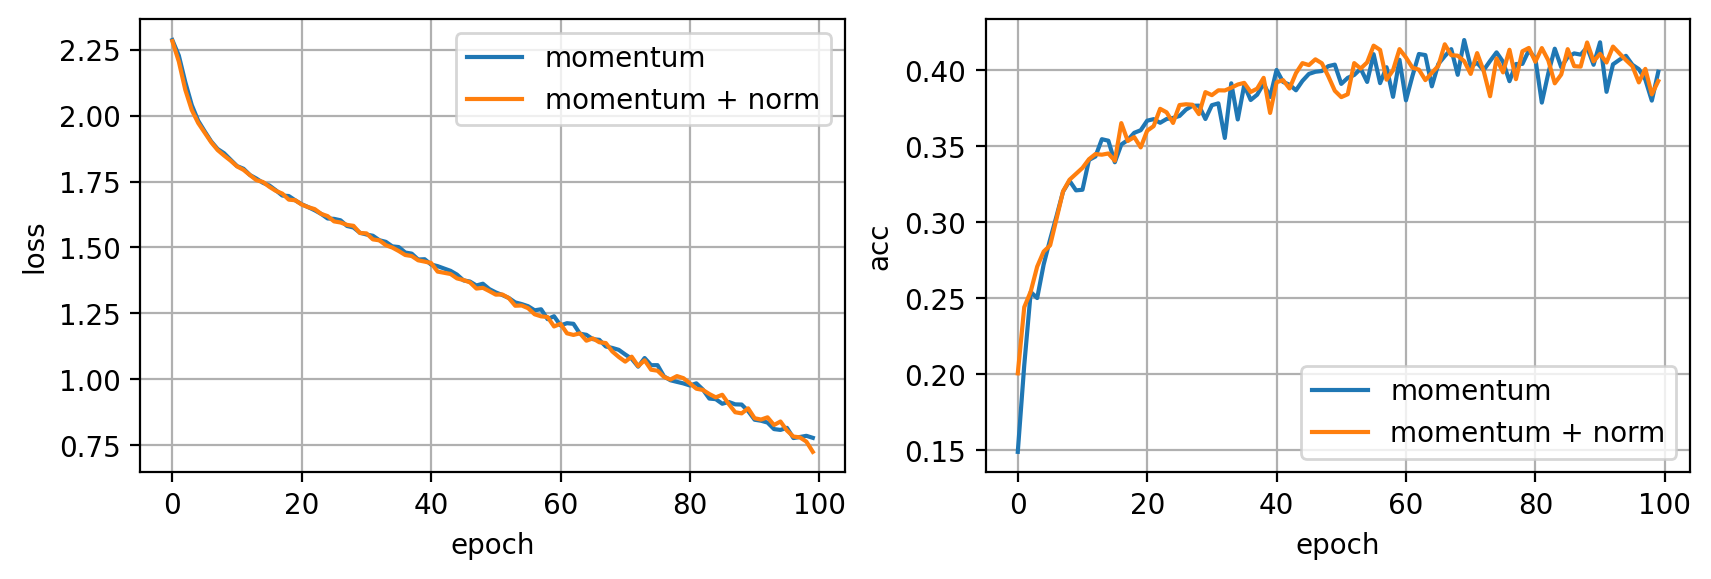

In [20]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(hist_momentum['loss'], label="momentum")
ax.plot(hist_norm['loss'], label="momentum + norm")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(hist_momentum['val_acc'], label="momentum")
ax.plot(hist_norm['val_acc'], label="momentum + norm")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

En este caso, el efecto de la normalización no es considerable (al trabajar con imágenes éste suele ser el caso).

### *Batch Normalization*

Otra forma de normalización muy importante que puede acelerar de manera dramática el entrenamiento es el *batch norm*. Podemos añadir esta capa en nuestras redes y su objetivo será el de normalizar sus entradas para que tengan media cero y desviación estándar 1. Además, aprenderá unos parámetros que le permitirán escalar y mover estos valores normalizados para mejorar sus representación, facilitando a la `red neuronal` la tarea de clasificación.

$$ \mu_B = \frac{1}{m_B} \sum_{i=1}^{m_B} x^{(i)} $$
$$ \sigma_B^2 = \frac{1}{m_B} \sum_{i=1}^{m_B} (x^{(i)} - \mu_B) $$
$$\hat{x}^{(i)} = \frac{x^{(i)} - \mu_b}{\sqrt{\sigma_B^2 + \epsilon}} $$ 
$$z^{(i)} = \gamma ⊗ \hat{x}^{(i)} + \beta $$ 

In [21]:
def build_model(D_in=32*32*3, H=100, D_out=10):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    ).cuda()

In [22]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
hist_bn = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.32600 en epoch 1
Mejor modelo guardado con acc 0.35050 en epoch 2
Mejor modelo guardado con acc 0.37820 en epoch 3
Epoch 10/100 loss 1.15643 acc 0.61963 val_loss 1.98355 val_acc 0.34240 lr 0.00100
Mejor modelo guardado con acc 0.38160 en epoch 11
Mejor modelo guardado con acc 0.38310 en epoch 12
Epoch 20/100 loss 0.68708 acc 0.78981 val_loss 2.24738 val_acc 0.34190 lr 0.00100
Epoch 30/100 loss 0.39911 acc 0.88097 val_loss 3.13841 val_acc 0.31300 lr 0.00100
Epoch 40/100 loss 0.29414 acc 0.91083 val_loss 2.69883 val_acc 0.36270 lr 0.00100
Epoch 50/100 loss 0.18638 acc 0.94745 val_loss 3.18939 val_acc 0.33770 lr 0.00100
Epoch 60/100 loss 0.11914 acc 0.96596 val_loss 3.47861 val_acc 0.33370 lr 0.00100
Epoch 70/100 loss 0.09221 acc 0.97691 val_loss 3.34135 val_acc 0.36690 lr 0.00100
Epoch 80/100 loss 0.16586 acc 0.95004 val_loss 3.28511 val_acc 0.36440 lr 0.00100
Epoch 90/100 loss 0.13978 acc 0.95521 val_loss 3.37921 val_acc 0.37000 lr 0.00100
Epoch 100/100 l

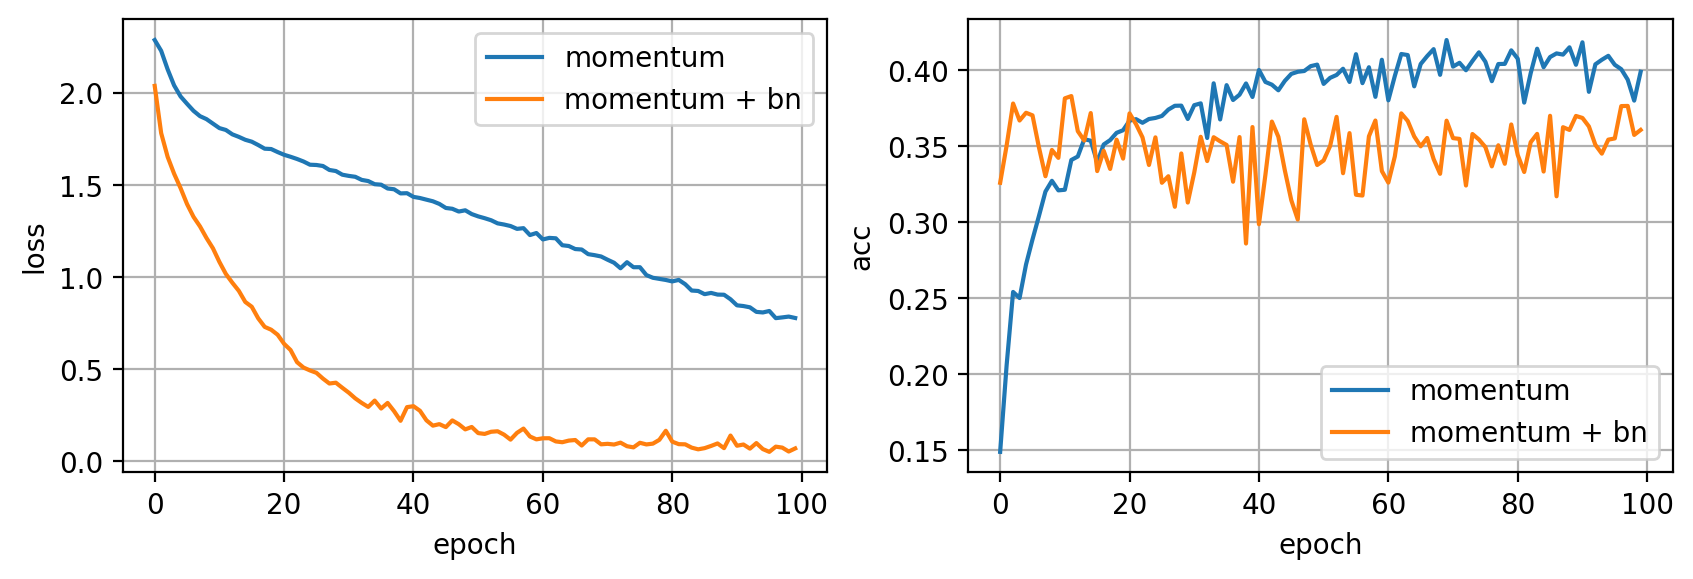

In [23]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(hist_momentum['loss'], label="momentum")
ax.plot(hist_bn['loss'], label="momentum + bn")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(hist_momentum['val_acc'], label="momentum")
ax.plot(hist_bn['val_acc'], label="momentum + bn")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

Como puedes observar, la introducción de la capa *Batch Norm* acelera muchísimo el entrenamiento, resultando en una reducción de la función de pérdida mucho más rápida (haciendo que nuestro modelo haga *overfitting* mucho más pronto). Combinando esta capa con alguna forma de [regularización](https://sensioai.com/blog/031_regularization), como por ejemplo *data augmentation* y *early stopping*, obtendremos buenos modelos capaces de generalizar de manera rápida.

## *Transfer Learning*

Posiblemente la técnica más interesante para acelerar el entrenamiento de un modelo es el *transfer learning*. No solo nos permite entrenar una red más rápido si no que además nos lo permite hacer con menos datos. Esta técnica consiste en utilizar una red ya entrenada en algún dataset como punto de partida para nuestro entrenamiento. Si nuestro dataset no es muy diferente al dataset utilizado originalmente para entrenar la red, es posible que podamos "transferir" el conocimiento que ya posee a nuestro caso. En la práctica, esta técnica funciona muy bien y nosotros la utilizaremos de manera extensiva en nuestras aplicaciones de ahora en adelante. En futuros posts entraremos en detalle en cómo aplicar transfer learning.

## Resumen 

En este post hemos presentado varias técnicas para acelerar el proceso de entrenamiento de una `red neuronal`. Combinando estas técnicas con las presentadas en los posts anteriores seremos capaces de entrenar modelos con buenas prestaciones de forma rápida. Hemos visto como podemos mejorar nuestro optimizador *SGD* para acelerar el proceso de optimización, también que podemos ir variando el *learning rate* durante el entrenamiento. La normalización de los datos y el uso de la capa *Batch Norm* también nos aportarán una aceleración considerable. Y, por último, si podemos usar una red preentrenada en una tarea similar a la nuestra seremos capaces de obtener un buen modelo de manera rápida y con pocos datos gracias al *transfer learning*. En el próximo post encontrarás una receta en la que combinamos todas las técnicas vistas y que puedes seguir para empezar a entrenar tus redes de forma efectiva.